# Pendientes

Nada

# Gpu

In [ ]:
!nvidia-smi

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

# Set_Up

In [ ]:

root_data = f'/content/drive/MyDrive/Course Folder/Forex/XAUUSD/'
print(root_data)

direction = 'Short'
direction_number = -1

symbol = 'XAUUSD'
strategy = 'Kalman'
time_frame = 'M5'

trade_evolution = 'st_Max'
result_field = 'st_PnL'


# Libraries

In [ ]:
!pip install ta-lib
import talib as ta
print(ta.__version__)

In [ ]:
import numpy as np
import pandas as pd
import os
import joblib
import math
import time

from itertools import combinations, product

from tqdm.auto import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from xgboost import XGBClassifier, XGBRegressor

import tensorflow as tf

import sys
sys.path.append("..")

from __future__ import annotations
from typing import Tuple, List, Optional, Dict, Any, Union

from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, log_loss, r2_score)

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Calculate_Features



## Features

In [ ]:
def kalman_line(source, kalman_length: int, smooth: int):
    """
    Pine -> Python (solo 'kalman_line'), replicando la EMA de TradingView con
    *semilla SMA* (como ta.ema) sobre el núcleo Kalman kf_c.

    Parámetros
    ----------
    source : pd.Series o array-like de floats (precio crudo, sin diff/returns)
    kalman_length : int   (equivale a length_kal en Pine)
    smooth : int          (equivale a smooth_kal en Pine -> ta.ema(kf_c, smooth))

    Retorna
    -------
    Mismo tipo que `source`: pd.Series o np.ndarray con la línea Kalman suavizada.
    """
    import numpy as np
    import pandas as pd

    # normalizamos tipos
    is_series = hasattr(source, "index")
    idx = source.index if is_series else None
    x = np.asarray(source, dtype=np.float64)
    n = x.shape[0]
    if n == 0:
        return source

    # ---------- núcleo Kalman idéntico al Pine ----------
    sqrt_term   = np.sqrt((kalman_length / 10000.0) * 2.0)
    length_term = kalman_length / 10000.0

    kf_c   = np.empty(n, dtype=np.float64)
    velo_c = np.empty(n, dtype=np.float64)

    # bar 0 (nz(kf_c[1], source) y nz(velo_c[1], 0))
    kf_c[0] = x[0]
    velo_c[0] = 0.0

    for i in range(1, n):
        prev_kf = kf_c[i - 1]
        dk_c = x[i] - prev_kf
        smooth_c = prev_kf + dk_c * sqrt_term
        velo_c[i] = velo_c[i - 1] + length_term * dk_c
        kf_c[i] = smooth_c + velo_c[i]

    # ---------- EMA con semilla SMA (comportamiento ta.ema de TV) ----------
    L = int(max(1, smooth))
    alpha = 2.0 / (L + 1.0)
    ema = np.full(n, np.nan, dtype=np.float64)

    if n < L:
        # con pocas barras, igualamos al promedio simple disponible
        ema[-1] = np.nanmean(kf_c)
    else:
        # seed = SMA de las primeras L barras
        seed = np.mean(kf_c[:L])
        ema[L - 1] = seed
        for i in range(L, n):
            ema[i] = alpha * kf_c[i] + (1.0 - alpha) * ema[i - 1]

    return (pd.Series(ema, index=idx) if is_series else ema)


In [ ]:
def create_features(
    stock_data: pd.DataFrame,
    return_components: bool = False
) -> Union[pd.DataFrame, Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]]:

    periods        = [3, 7, 14]
    kalman_periods = [300, 600, 900]

    component_frames: Dict[str, pd.DataFrame] = {}

    def _unique_pairwise(columns: List[str]) -> List[Tuple[str, str]]:
        """Return ordered unique column pairs without self-pairings."""
        unique_columns = list(dict.fromkeys(columns))
        return list(combinations(unique_columns, 2))

    # ───────────────────────── Kalman y derivados ───────────────────────
    t0 = time.time()
    kal_cols = []
    kalman_features = pd.DataFrame(index=stock_data.index)
    kalman_900_series: Optional[pd.Series] = None
    for period in tqdm(kalman_periods, desc="Kalman & Derivatives"):
        kal = pd.Series(
            kalman_line(stock_data['Close'], kalman_length=period, smooth=3),
            index=stock_data.index
        )
        kname = f'Kal_{period}'
        kal_cols.append(kname)

        kalman_features[kname] = kal
        if period == 900:
            kalman_900_series = kal

        kalman_features[f'Close_Kal_{period}']  = stock_data['Close'] - kal
        kalman_features[f'Kal_change_{period}'] = kal.diff(1)

    kal_pairs = _unique_pairwise(kal_cols)
    for c1, c2 in tqdm(kal_pairs, desc="Kalman pairwise"):
        kalman_features[f'{c1}_minus_{c2}'] = kalman_features[c1] - kalman_features[c2]

    tqdm.write(f"[Timing] Kalman block: {time.time()-t0:.2f}s")
    component_frames['Kalman'] = kalman_features.copy()
    features = kalman_features.copy()

    # ───────────────────────── RSI (Close & Kalman_900) ────────────────────
    t0 = time.time()
    rsi_features = pd.DataFrame(index=stock_data.index)
    rsi_sources: Dict[str, pd.Series] = {'Close': stock_data['Close']}
    if kalman_900_series is not None:
        rsi_sources['Kalman_900'] = kalman_900_series

    for source_name, series in rsi_sources.items():
        rsi_cols: List[str] = []
        for period in tqdm(periods, desc=f"RSI ({source_name})", leave=False):
            if source_name == 'Close':
                col_name = f'RSI_{period}'
            else:
                col_name = f'RSI_{source_name}_{period}'
            rsi_features[col_name] = ta.RSI(series, timeperiod=period)
            rsi_cols.append(col_name)

        for col in tqdm(rsi_cols, desc=f"RSI ({source_name}) diffs", leave=False):
            rsi_features[f'{col}_diff'] = rsi_features[col].diff()

        for col1, col2 in tqdm(_unique_pairwise(rsi_cols), desc=f"RSI ({source_name}) pairwise", leave=False):
            rsi_features[f'{col1} - {col2}'] = rsi_features[col1] - rsi_features[col2]

    tqdm.write(f"[Timing] RSI block: {time.time()-t0:.2f}s")
    component_frames['RSI'] = rsi_features.copy()
    features = pd.concat([features, rsi_features], axis=1)

    if return_components:
        component_frames['Create_Features'] = features.copy()
        return features, component_frames

    return features

In [ ]:
def scale_feature_block(features: pd.DataFrame, window: int = 200) -> pd.DataFrame:
    """Scale features using a rolling window standardization.

    Parameters
    ----------
    features : pd.DataFrame
        Feature block to scale.
    window : int, optional
        Rolling window size, by default 200.

    Returns
    -------
    pd.DataFrame
        Scaled feature block preserving the original index.
    """
    if features.empty:
        return features.copy()

    scaled = features.copy()
    rolling = scaled.rolling(window)
    scaled = (scaled - rolling.mean()) / rolling.std()
    return scaled


## 5_min

In [ ]:
# Read the CSV file
df_5min = pd.read_csv(root_data + 'Data/'+symbol+'_M5.csv', index_col=0)
df_5min.index = pd.to_datetime(df_5min.index)
#df_5min = df_5min.iloc[-50000:,]

print('Min_Date : ', df_5min.index.min())
print('Min_Date : ', df_5min.index.max())
print('Number_Rows = ',len(df_5min.index))
print('\n')

df_5min.tail()

**Features**

In [ ]:
start_time = time.time()

features_5min_raw, components_5min = create_features(df_5min, return_components=True)
features_5min_raw = features_5min_raw.dropna()
valid_index_5min = features_5min_raw.index

# Align every component to the valid index coming from the full feature set
m5_raw_blocks: Dict[str, pd.DataFrame] = {name: frame.loc[valid_index_5min].copy()
                                           for name, frame in components_5min.items()}
m5_raw_blocks['Create_Features'] = features_5min_raw

m5_scaled_blocks: Dict[str, pd.DataFrame] = {}
m5_raw_paths: Dict[str, str] = {}
m5_scaled_paths: Dict[str, str] = {}

for name, frame in m5_raw_blocks.items():
    filename_raw = f"{symbol}_M5_{name}_Raw_Features.csv" if name != 'Create_Features' else f"{symbol}_M5_Raw_Features.csv"
    raw_path = os.path.join(root_data, 'Results', filename_raw)
    frame.to_csv(raw_path)
    m5_raw_paths[name] = raw_path

    scaled_frame = scale_feature_block(frame)
    m5_scaled_blocks[name] = scaled_frame
    filename_scale = f"{symbol}_M5_{name}_Scale_Features.csv" if name != 'Create_Features' else f"{symbol}_M5_Scale_Features.csv"
    scale_path = os.path.join(root_data, 'Results', filename_scale)
    scaled_frame.to_csv(scale_path)
    m5_scaled_paths[name] = scale_path

execution_time = time.time() - start_time

print(f"Number of features are: {features_5min_raw.shape[1]}")
print(features_5min_raw.shape)
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Saved {len(m5_raw_blocks) * 2} DataFrames for the M5 timeframe.")
features_5min_raw.tail(5)


In [ ]:
print("NaN counts per column (sorted):")
print(m5_raw_blocks['Create_Features'].isnull().sum().sort_values(ascending=False), '')

In [ ]:
print("Saved raw feature files:")
for name, path in m5_raw_paths.items():
    print(f" - {name}: {path}")

In [ ]:
print(list(features_5min_raw.columns))

**Scale_features**

In [ ]:
print("Saved scaled feature files:")
for name, path in m5_scaled_paths.items():
    print(f" - {name}: {path}")


In [ ]:
m5_scaled_blocks['Create_Features'].head()

In [18]:
print("NaN counts per column (scaled, sorted):")
print(m5_scaled_blocks['Create_Features'].isnull().sum().sort_values(ascending=False), '')

NaN counts per column (scaled, sorted):
Kal_300                                 199
Close_Kal_300                           199
Kal_change_300                          199
Kal_600                                 199
Close_Kal_600                           199
Kal_change_600                          199
Kal_900                                 199
Close_Kal_900                           199
Kal_change_900                          199
Kal_300_minus_Kal_600                   199
Kal_300_minus_Kal_900                   199
Kal_600_minus_Kal_900                   199
RSI_3                                   199
RSI_7                                   199
RSI_14                                  199
RSI_3_diff                              199
RSI_7_diff                              199
RSI_14_diff                             199
RSI_3 - RSI_7                           199
RSI_3 - RSI_14                          199
RSI_7 - RSI_14                          199
RSI_Kalman_900_3                    

In [19]:
print("M5 feature blocks:", list(m5_raw_blocks.keys()))

M5 feature blocks: ['Kalman', 'RSI', 'Create_Features']


**Plots**

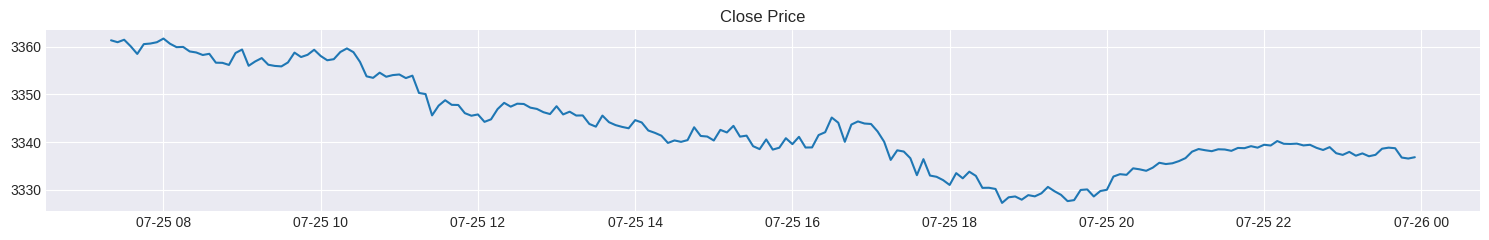

In [20]:
import matplotlib.pyplot as plt

last_200_features_5min = m5_scaled_blocks['Create_Features'].tail(200)
last_200_df_5min = df_5min.tail(200)

indicators_to_plot = ['Close','5min_Kal_300','5min_Kal_600']

# Separate Close from other indicators
close_to_plot = 'Close' if 'Close' in indicators_to_plot else None
other_indicators_to_plot = [col for col in indicators_to_plot if col != 'Close' and col in last_200_features_5min.columns]

num_plots = len(other_indicators_to_plot) + (1 if close_to_plot else 0)

# Plotting
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 2.5 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Close price if requested
if close_to_plot:
    axes[current_plot_index].plot(last_200_df_5min.index, last_200_df_5min['Close'])
    axes[current_plot_index].set_title('Close Price')
    axes[current_plot_index].grid(True)
    current_plot_index += 1

# Plot each selected indicator (excluding 'Close')
for col in other_indicators_to_plot:
    axes[current_plot_index].plot(last_200_features_5min.index, last_200_features_5min[col])
    axes[current_plot_index].set_title(col)
    axes[current_plot_index].grid(True)
    current_plot_index += 1

plt.tight_layout()
plt.show()


# Feature Importance

## Labels

In [21]:
lab = pd.read_csv(root_data + 'Results/'+symbol+'_'+strategy+'_'+time_frame+'_Strategy_Gen_Labels.csv', index_col=0)
lab['Date'] = pd.to_datetime(lab['Date'])

print('Min_Date    : ',lab['Date'].min())
print('Min_Date    : ',lab['Date'].max(),'\n')
print('Number_Rows : ',lab.shape,'\n')
print('Columns     : ',lab.columns)

lab['Open_Trade'].value_counts()

Min_Date    :  2019-01-02 01:00:00
Min_Date    :  2025-07-25 23:55:00 

Number_Rows :  (465718, 32) 

Columns     :  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Spread', 'ATR',
       'kal_1', 'kal_2', 'kal_3', 'kal_4', 'Open_Trade', 'Close_Trade',
       'Entry_Date', 'Type', 'Trade_Number', 'st_Exit_Date',
       'consecutive_trade_period', 'atr_base_change_abs', 'atr_base_change_%',
       'trade type', 'st_Duration', 'st_row_PnL_close', 'st_row_PnL_high',
       'st_row_PnL_Low', 'st_row_PnL_low', 'st_Max', 'st_Min', 'st_PnL',
       'st_atr_PnL', 'st_atr_max_PnL'],
      dtype='object')


,count
Open_Trade,
1.0,33915
-1.0,33858


In [ ]:
#analyse_column = 'st_atr_max_PnL'
analyse_column = 'st_Max'

st_max_0  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].sum()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].sum()


st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 0)),analyse_column].sum()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 0.7) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].sum()

st_max_5 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1) &
                   (lab['st_atr_max_PnL'] <= 1.5)),analyse_column].sum()

st_max_6 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1.5) &
                   (lab['st_atr_max_PnL'] <= 2)),analyse_column].sum()

st_max_7 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 2)),analyse_column].sum()


print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 & <= 1.5 = {st_max_5:,.2f}')
print(f'> 1.5 & <= 2 = {st_max_6:,.2f}')
print(f'> 2 = {st_max_7:,.2f}')

In [ ]:
analyse_column = 'st_atr_max_PnL'

st_max_0 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].count()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].count()

st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                    (lab['st_atr_max_PnL'] <= 0.5)),analyse_column].count()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                     (lab['st_atr_max_PnL'] >= 0.5) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].count()

st_max_5 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] >= 1), analyse_column].count()

print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 = {st_max_5:,.2f}')


In [29]:
# --- Parámetros / campos
result_field = 'st_atr_max_PnL'

#valid = (
#    (lab['Type'] == direction) &
#    (lab['Open_Trade'].isin([1, -1])) &
#    (lab[result_field].notna()))

valid = (
    (lab['Open_Trade'].isin([1, -1])) &
    (lab[result_field].notna()))


# --- Etiquetado en la columna "label" con valores 4/5/6
lab['label'] = np.nan
lab.loc[valid & (lab[result_field] <= 1), 'label'] = 0
lab.loc[valid & (lab[result_field] >= 1), 'label'] = 1


# --- Mantener solo filas válidas y con label
lab = lab.loc[valid & lab['label'].notna()].copy()
lab['label'] = lab['label'].astype('int8')

# --- Ver distribución de labels 4/5/6
print('\nValue counts de label 4/5/6:')
print(lab['label'].value_counts(dropna=False).sort_index())



Value counts de label 4/5/6:
label
0    33547
1    34223
Name: count, dtype: int64


## Features

In [27]:
raw_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
raw_feat_5min["Date"] = pd.to_datetime(raw_feat_5min["Date"])
print(raw_feat_5min.shape)
#raw_feat_5min.head(5)

(465701, 31)


In [28]:
scale_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Scale_Features.csv')
#scale_feat_5min = scale_feat_5min.drop('Unnamed: 0', axis=1)
scale_feat_5min["Date"] = pd.to_datetime(scale_feat_5min["Date"])
print(scale_feat_5min.shape)
#scale_feat_5min.head(5)

(465701, 31)


## Merge

In [47]:
data_type = 'Scale'

In [59]:
def prepare_feature_block(frame: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """Return a copy of the feature block with a consistent prefix."""
    block = frame.copy()
    if 'Unnamed: 0' in block.columns:
        block = block.drop(columns='Unnamed: 0')
    block = block.drop_duplicates(subset='Date').sort_values('Date')
    rename_map = {col: f"{prefix}{col}" for col in block.columns if col != 'Date'}
    block = block.rename(columns=rename_map)
    return block

feature_blocks = {
    'M5_raw': prepare_feature_block(raw_feat_5min, 'M5_raw_'),
    'M5_scale': prepare_feature_block(scale_feat_5min, 'M5_scale_'),
}

feature_df = lab[['Date']].drop_duplicates().copy()

print('Feature blocks merged:')
for name, block in feature_blocks.items():
    feature_df = feature_df.merge(block, on='Date', how='left')
    print(f" - {name}: {block.shape[1] - 1} columns")

feature_df = feature_df.sort_values('Date').set_index('Date').ffill().reset_index()

df = lab[['Date', 'Close','label', 'Open_Trade','kal_1', 'kal_2', 'kal_3', 'kal_4']].merge(feature_df, on='Date', how='left')

cols = df.columns.tolist()
cols.remove('label')
cols.insert(1, 'label')
df = df[cols]

combined_feature_path = os.path.join(root_data, 'Results', f"{symbol}_{direction}_AllFeatures.csv")
df.to_csv(combined_feature_path, index=False)

print(f"Combined feature dataframe shape: {df.shape}")
print(f"Saved combined feature dataframe to: {combined_feature_path}")

Feature blocks merged:
 - M5_raw: 30 columns
 - M5_scale: 30 columns
Combined feature dataframe shape: (67770, 68)
Saved combined feature dataframe to: /content/drive/MyDrive/Course Folder/Forex/XAUUSD/Results/XAUUSD_Short_AllFeatures.csv


In [60]:
expected_prefixes = ['M5_raw_', 'M5_scale_']
for prefix in expected_prefixes:
    matching_cols = [col for col in df.columns if col.startswith(prefix)]
    print(f"{prefix}: {len(matching_cols)} columns")

duplicated_columns = df.columns[df.columns.duplicated()].tolist()
if duplicated_columns:
    print('Duplicated feature columns detected:', duplicated_columns)
else:
    print('No duplicated feature columns detected.')

M5_raw_: 30 columns
M5_scale_: 30 columns
No duplicated feature columns detected.


In [61]:
print(df.shape,'\n')
print('Label_Counts : ',df.label.value_counts(),'\n')
print(list(df.columns), '\n')

# Add NaN count per column, sorted
print("NaN counts per column (sorted):")
print(df.isnull().sum().sort_values(ascending=False), '\n')

#df.head(5)

(67770, 68) 

Label_Counts :  label
1    34223
0    33547
Name: count, dtype: int64 

['Date', 'label', 'Close', 'Open_Trade', 'kal_1', 'kal_2', 'kal_3', 'kal_4', 'M5_raw_Kal_300', 'M5_raw_Close_Kal_300', 'M5_raw_Kal_change_300', 'M5_raw_Kal_600', 'M5_raw_Close_Kal_600', 'M5_raw_Kal_change_600', 'M5_raw_Kal_900', 'M5_raw_Close_Kal_900', 'M5_raw_Kal_change_900', 'M5_raw_Kal_300_minus_Kal_600', 'M5_raw_Kal_300_minus_Kal_900', 'M5_raw_Kal_600_minus_Kal_900', 'M5_raw_RSI_3', 'M5_raw_RSI_7', 'M5_raw_RSI_14', 'M5_raw_RSI_3_diff', 'M5_raw_RSI_7_diff', 'M5_raw_RSI_14_diff', 'M5_raw_RSI_3 - RSI_7', 'M5_raw_RSI_3 - RSI_14', 'M5_raw_RSI_7 - RSI_14', 'M5_raw_RSI_Kalman_900_3', 'M5_raw_RSI_Kalman_900_7', 'M5_raw_RSI_Kalman_900_14', 'M5_raw_RSI_Kalman_900_3_diff', 'M5_raw_RSI_Kalman_900_7_diff', 'M5_raw_RSI_Kalman_900_14_diff', 'M5_raw_RSI_Kalman_900_3 - RSI_Kalman_900_7', 'M5_raw_RSI_Kalman_900_3 - RSI_Kalman_900_14', 'M5_raw_RSI_Kalman_900_7 - RSI_Kalman_900_14', 'M5_scale_Kal_300', 'M5_scale_Clos

In [62]:
# Remove columns with 'raw' or 'RSI' in their name from df
#cols_to_drop = [col for col in df.columns if 'raw' in col or 'RSI' in col]
cols_to_drop = [col for col in df.columns if 'raw' in col]
df = df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped {len(cols_to_drop)} columns containing 'raw' or 'RSI'.")

Dropped 48 columns containing 'raw' or 'RSI'.


In [56]:
print(list(df.columns), '\n')

['Date', 'label', 'Close', 'Open_Trade', 'kal_1', 'kal_2', 'kal_3', 'kal_4', 'M5_scale_Kal_300', 'M5_scale_Close_Kal_300', 'M5_scale_Kal_change_300', 'M5_scale_Kal_600', 'M5_scale_Close_Kal_600', 'M5_scale_Kal_change_600', 'M5_scale_Kal_900', 'M5_scale_Close_Kal_900', 'M5_scale_Kal_change_900', 'M5_scale_Kal_300_minus_Kal_600', 'M5_scale_Kal_300_minus_Kal_900', 'M5_scale_Kal_600_minus_Kal_900'] 



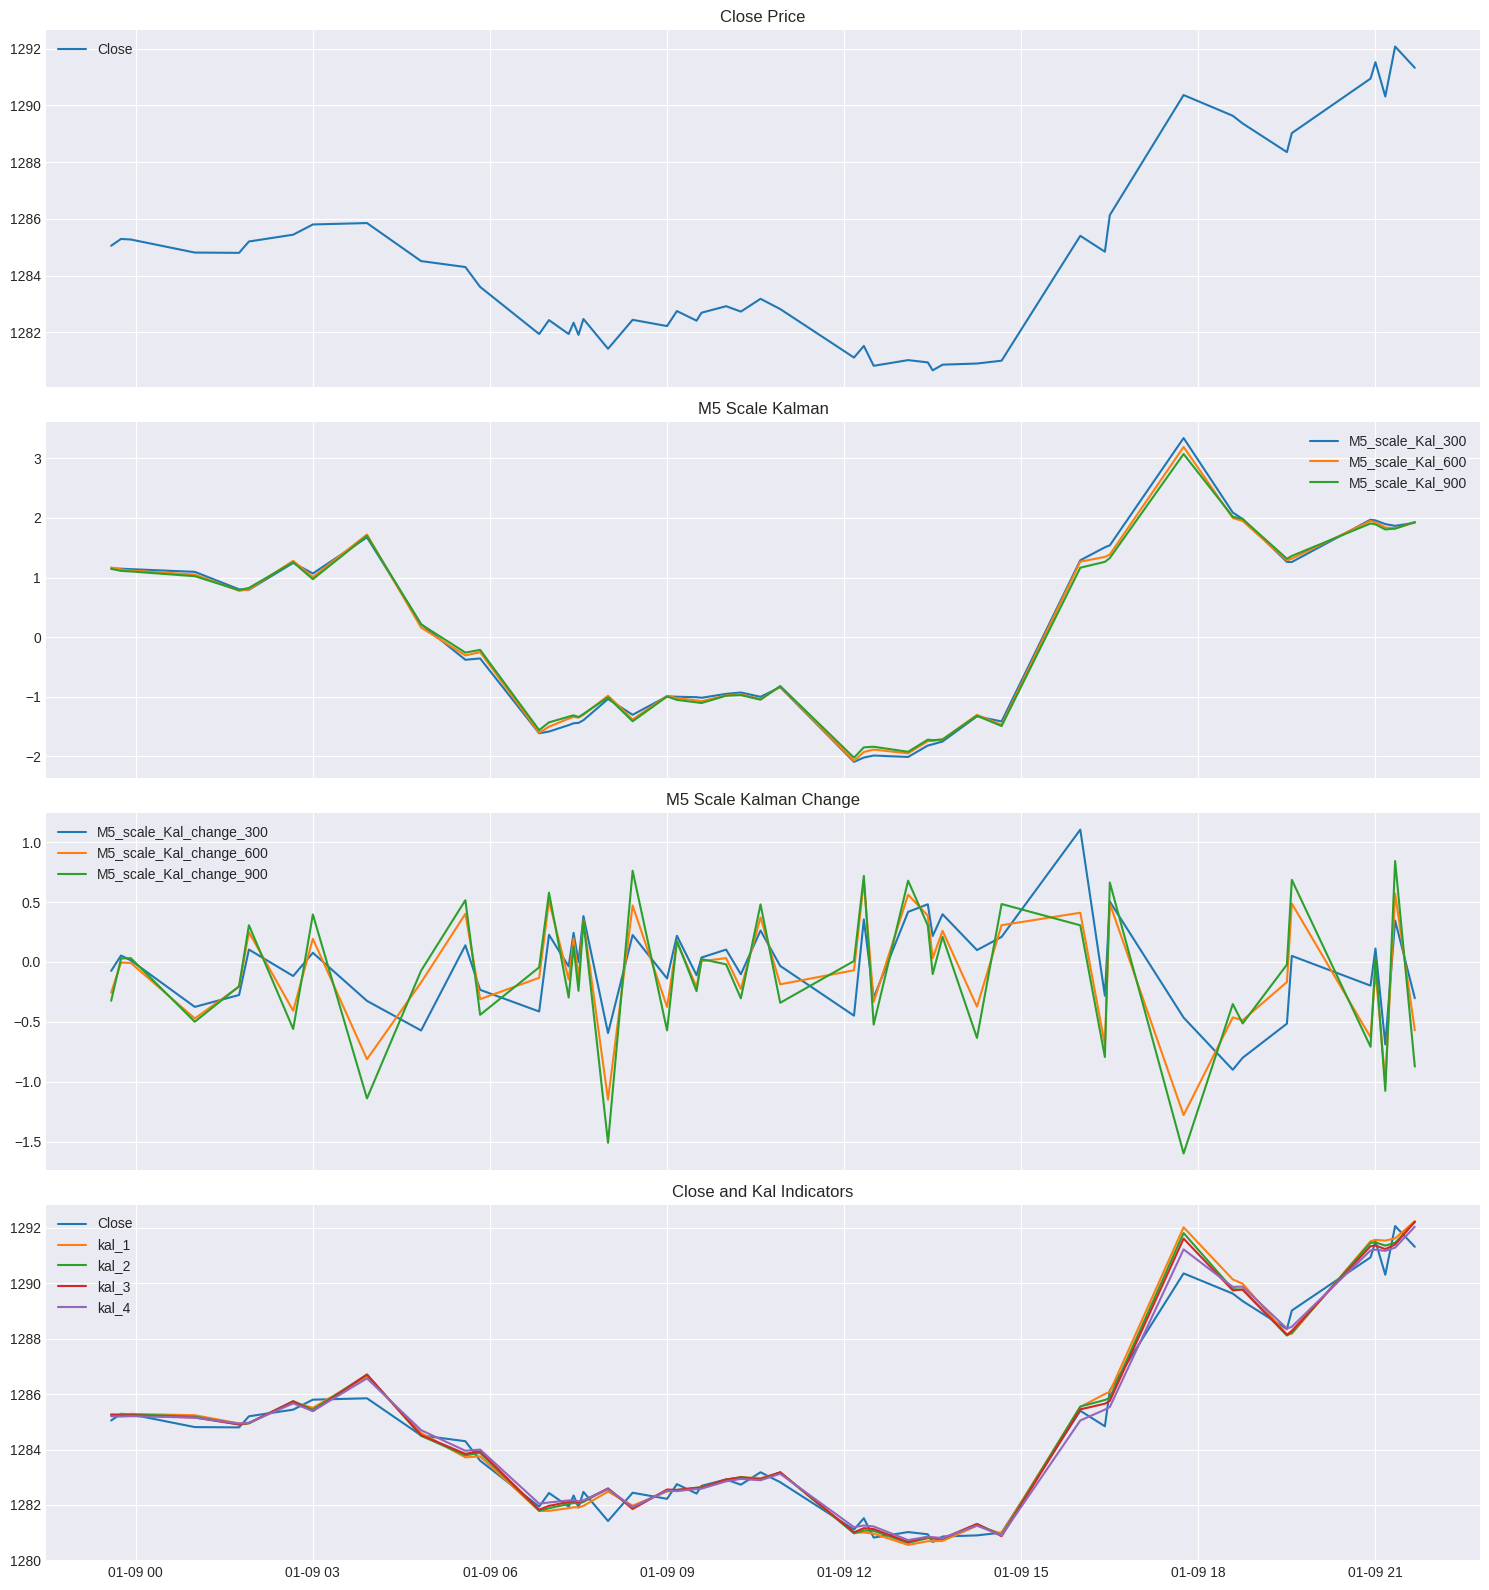

In [58]:
import matplotlib.pyplot as plt

# Define the row range for plotting
start_row = 200
end_row = 250

# Select the data for the specified row range from df
plot_df = df.iloc[start_row:end_row].copy()

# Define the columns to plot in each chart
chart1_cols = ['Close'] # Assuming 'Close' is now in df
chart2_cols = ['M5_scale_Kal_300', 'M5_scale_Kal_600', 'M5_scale_Kal_900']
chart3_cols = ['M5_scale_Kal_change_300', 'M5_scale_Kal_change_600', 'M5_scale_Kal_change_900']
chart4_cols = ['kal_1', 'kal_2', 'kal_3', 'kal_4']

# Determine the number of subplots (only include charts with available columns in plot_df)
num_plots = 0
if any(col in plot_df.columns for col in chart1_cols): num_plots += 1
if any(col in plot_df.columns for col in chart2_cols): num_plots += 1
if any(col in plot_df.columns for col in chart3_cols): num_plots += 1
if any(col in plot_df.columns for col in chart4_cols): num_plots += 1


# Create the subplots
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 4 * num_plots), sharex=True)

# Ensure axes is an array even if only one plot
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

current_plot_index = 0

# Plot Chart 1: Close Price
if any(col in plot_df.columns for col in chart1_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart1_cols])
    axes[current_plot_index].set_title('Close Price')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart1_cols)
    current_plot_index += 1


# Plot Chart 2: M5 Scale Kalman indicators
if any(col in plot_df.columns for col in chart2_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart2_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart2_cols)
    current_plot_index += 1

# Plot Chart 3: M5 Scale Kalman Change indicators
if any(col in plot_df.columns for col in chart3_cols):
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart3_cols])
    axes[current_plot_index].set_title('M5 Scale Kalman Change')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart3_cols)
    current_plot_index += 1

# Plot Chart 4: Close and Kal indicators
if any(col in plot_df.columns for col in chart4_cols):
    # Combine Close and kal columns from plot_df
    chart4_combined_cols = chart1_cols + chart4_cols
    axes[current_plot_index].plot(plot_df['Date'], plot_df[chart4_combined_cols])
    axes[current_plot_index].set_title('Close and Kal Indicators')
    axes[current_plot_index].grid(True)
    axes[current_plot_index].legend(chart4_combined_cols)
    current_plot_index += 1


plt.tight_layout()
plt.show()

In [46]:
### Align feature directions so that shorts mirror longs
if 'Open_Trade' not in df.columns:
    raise KeyError("'Open_Trade' column is required in df to flip feature signs.")

### Identify feature columns to flip (exclude identifiers/targets).
feature_cols = [col for col in df.columns if col not in ['Date', 'label', 'Open_Trade', 'Close']] # Keep 'Close'
short_mask = df['Open_Trade'] == -1

if short_mask.any():
    df.loc[short_mask, feature_cols] = df.loc[short_mask, feature_cols] * -1
    print(f"Flipped {short_mask.sum()} rows with Open_Trade = -1.")
else:
    print("No rows with Open_Trade = -1 were found.")

### Reorder columns so Open_Trade stays next to the label for downstream steps.
ordered_cols = ['Date', 'label', 'Open_Trade'] + [col for col in feature_cols]
df_diff = df_diff[ordered_cols]

# Remove columns with 'raw' or 'RSI' in their name from df, but keep 'Close'
cols_to_drop = [col for col in df.columns if ('raw' in col or 'RSI' in col) and col != 'Close']
df = df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped {len(cols_to_drop)} columns containing 'raw' or 'RSI' (keeping 'Close').")

Flipped 33857 rows with Open_Trade = -1.


NameError: name 'df_diff' is not defined

## ML

In [ ]:
# ===================== 1. ENTRENAR Y OBTENER IMPORTANCIAS =====================
def compute_xgb_importance(
    X: pd.DataFrame,
    y: pd.Series,
    task: str = "classification",
    random_state: int = 42,
    **xgb_params: Any
) -> Tuple[pd.DataFrame, Any]:
    """
    Entrena un modelo XGBoost y devuelve:
      - imp_df: DataFrame con 'feature', 'importance' y 'cum_importance'.
      - model : modelo ya entrenado.

    Soporta:
      • Clasificación binaria o multiclase (detecta nº de clases).
      • Regresión (si task != 'classification').

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características (sin la columna objetivo).
    y : pd.Series
        Etiquetas objetivo. Puede ser binaria (0/1) o multiclase (0..K-1).
    task : str, opcional
        "classification" (default) o "regression".
    random_state : int, opcional
        Semilla para reproducibilidad.
    **xgb_params : dict
        Parámetros adicionales para el estimador de XGBoost.

    Returns
    -------
    (imp_df, model)
        imp_df : DataFrame con importancias y su acumulado.
        model  : instancia entrenada de XGBClassifier / XGBRegressor.
    """
    default_params: Dict[str, Any] = dict(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )
    default_params.update(xgb_params)

    if task == "classification":
        # Detectar nº de clases
        classes = np.unique(y)
        n_classes = len(classes)

        # XGBClassifier ajusta objetivo automáticamente, pero lo explicitamos:
        if n_classes > 2:
            default_params.setdefault("objective", "multi:softprob")
            default_params.setdefault("num_class", n_classes)
            eval_metric = "mlogloss"
        else:
            default_params.setdefault("objective", "binary:logistic")
            eval_metric = "logloss"

        model = XGBClassifier(eval_metric=eval_metric, **default_params)

    else:
        model = XGBRegressor(**default_params)

    model.fit(X, y)

    imp_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    total_imp = imp_df["importance"].sum()
    if total_imp == 0:
        # Evitar división por cero si el modelo devuelve todo cero (raro, pero posible)
        imp_df["cum_importance"] = 0.0
    else:
        imp_df["cum_importance"] = imp_df["importance"].cumsum() / total_imp

    return imp_df, model

In [ ]:
# ===================== 2. SELECCIÓN DE FEATURES =====================
def select_features_with_importance(
    X: pd.DataFrame,
    imp_df: pd.DataFrame,
    top_n: Optional[int] = None,
    threshold: Optional[str | float] = None,
    cum_threshold: Optional[float] = 0.8
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Selección flexible de variables a partir de importancias de XGBoost.

    Reglas:
      - Si top_n no es None           => usa el top_n.
      - Else si cum_threshold no None => usa importancia acumulada (p.ej. 0.8 = 80%).
      - Else usa threshold ('median', 'mean' o valor numérico).

    Devuelve (X_reducido, lista_de_features).

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características original.
    imp_df : pd.DataFrame
        DataFrame devuelto por compute_xgb_importance.
    top_n : int | None
        Número fijo de variables a conservar.
    threshold : str | float | None
        Umbral de importancia. Si str, usar 'median' o 'mean'.
    cum_threshold : float | None
        Porcentaje acumulado de importancia (0-1). Si None, se ignora.

    Returns
    -------
    (X_sel, keep)
        X_sel : subset de X con columnas seleccionadas.
        keep  : lista de nombres de columnas seleccionadas.
    """
    if top_n is not None:
        keep = imp_df.head(top_n)["feature"].tolist()

    elif cum_threshold is not None:
        keep_mask = imp_df["cum_importance"] <= float(cum_threshold)
        keep = imp_df.loc[keep_mask, "feature"].tolist()
        # asegurar que haya al menos una más para no quedarnos exactamente en el corte
        if len(keep) < len(imp_df):
            keep.append(imp_df.iloc[len(keep)]["feature"])

    else:
        if threshold is None:
            threshold = "median"
        if isinstance(threshold, str):
            thr_val = imp_df["importance"].agg(threshold)
        else:
            thr_val = float(threshold)
        keep = imp_df.loc[imp_df["importance"] >= thr_val, "feature"].tolist()

    return X[keep], keep

In [ ]:
# ===================== 3. BÚSQUEDA DEL MEJOR UMBRAL ACUMULADO =====================
def find_best_cum_threshold(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    task: str = "classification",
    thresholds: Tuple[float, ...] = (0.6, 0.7, 0.8, 0.9),
    random_state: int = 42,
    metric: str = "auto",
    **xgb_params: Any
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Entrena un XGB en train, calcula importancias y prueba varios umbrales
    acumulados para ver cuál da la mejor métrica en valid.

    Para CLASIFICACIÓN:
        - Detecta nº de clases.
        - Métrica por defecto (metric="auto"):
            • Binaria: ROC-AUC (probabilidades de la clase positiva).
            • Multiclase: ROC-AUC macro OVR (usa predict_proba).
          Alternativas: metric="f1_macro", "accuracy", "logloss" (se MINIMIZA).
    Para REGRESIÓN:
        - Usa R^2.

    Devuelve:
        best_thr, res_df_ordenado_por_score_desc, imp_df

    Parámetros
    ----------
    X_train, y_train, X_valid, y_valid : pd.DataFrame / pd.Series
        Particiones de entrenamiento y validación.
    task : str
        "classification" (default) o "regression".
    thresholds : tuple[float, ...]
        Valores de umbral de importancia acumulada a evaluar (0-1).
    random_state : int
        Semilla para reproducibilidad.
    metric : str
        "auto" (default), "roc_auc", "f1_macro", "accuracy", "logloss" (clasif) o "r2" (regresión).
    **xgb_params : dict
        Parámetros extra para el estimador de XGBoost (pasan a compute y a los modelos internos).

    Returns
    -------
    (best_thr, res_df, imp_df)
        best_thr : float
            Umbral con mejor score (o menor logloss si metric='logloss').
        res_df : pd.DataFrame
            Tabla con resultados por umbral (n_features, score).
        imp_df : pd.DataFrame
            Importancias calculadas en X_train / y_train.
    """
    imp_df, _ = compute_xgb_importance(
        X_train, y_train, task=task, random_state=random_state, **xgb_params
    )

    results = []

    # Detectar nº de clases si es clasificación
    if task == "classification":
        classes = np.unique(y_train)
        n_classes = len(classes)
        if metric == "auto":
            metric_to_use = "roc_auc" if n_classes == 2 else "roc_auc"
        else:
            metric_to_use = metric
    else:
        metric_to_use = "r2" if metric == "auto" else metric

    for thr in thresholds:
        X_tr_sel, cols = select_features_with_importance(
            X_train, imp_df, cum_threshold=thr, top_n=None, threshold=None
        )
        X_va_sel = X_valid[cols]

        if task == "classification":
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)

            if n_classes > 2:
                params.setdefault("objective", "multi:softprob")
                params.setdefault("num_class", n_classes)
                eval_metric = "mlogloss"
            else:
                params.setdefault("objective", "binary:logistic")
                eval_metric = "logloss"

            model_sel = XGBClassifier(eval_metric=eval_metric, **params)
            model_sel.fit(X_tr_sel, y_train)

            # Probabilidades y predicciones
            proba = model_sel.predict_proba(X_va_sel)
            pred  = np.argmax(proba, axis=1) if n_classes > 2 else (proba[:, 1] >= 0.5).astype(int)

            # Calcular métrica
            if metric_to_use == "roc_auc":
                if n_classes == 2:
                    score = roc_auc_score(y_valid, proba[:, 1])
                else:
                    # AUC macro One-vs-Rest
                    score = roc_auc_score(y_valid, proba, multi_class="ovr", average="macro")
            elif metric_to_use == "f1_macro":
                score = f1_score(y_valid, pred, average="macro")
            elif metric_to_use == "accuracy":
                score = accuracy_score(y_valid, pred)
            elif metric_to_use == "logloss":
                # En este caso, menor es mejor. Guardamos negativo para mantener criterio "mayor mejor".
                score = -log_loss(y_valid, proba, labels=np.unique(y_train))
            else:
                raise ValueError(f"Métrica no soportada: {metric_to_use}")

        else:
            # REGRESIÓN
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)
            model_sel = XGBRegressor(**params)
            model_sel.fit(X_tr_sel, y_train)
            pred = model_sel.predict(X_va_sel)

            if metric_to_use == "r2":
                score = r2_score(y_valid, pred)
            else:
                raise ValueError(f"Métrica de regresión no soportada: {metric_to_use}")

        results.append({"cum_threshold": thr, "n_features": len(cols), "score": score})

    # Ordenar (si usamos logloss negado, mayor sigue siendo mejor)
    res_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)
    best_thr = float(res_df.iloc[0]["cum_threshold"])
    return best_thr, res_df, imp_df

In [ ]:
def remove_highly_correlated_features(df, threshold=0.9):

    # Solo numéricos para evitar errores y acelerar
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))

    to_drop = []
    for col in tqdm(upper.columns, desc=f"Pruning corr > {threshold}", unit="col", leave=False):
        if (upper[col] > threshold).any():
            to_drop.append(col)

    return df.drop(columns=to_drop, errors="ignore"), to_drop


In [ ]:
# ===================== 3. PIPELINE PRINCIPAL =====================
df = df.dropna()
y = df['label']
X = df.iloc[:, 2:]

# --- 3.3 Split temporal (ejemplo simple 80/20) ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 3.4 Remove correlated features ---
X_train_filtered, dropped_features = remove_highly_correlated_features(X_train, threshold=0.9)
X_test_filtered = X_test.drop(columns=dropped_features)

# Baseline logistic regression with time-series CV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_filtered)
tscv = TimeSeriesSplit(n_splits=5)
baseline = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y_train, cv=tscv).mean()
print('Logistic regression CV accuracy:', baseline)

# --- 3.5 Importancias con XGBoost ---
imp_df, xgb_model = compute_xgb_importance(X_train_filtered, y_train, task='classification')

print('=== Importancias XGBoost ===')
print(imp_df.head(20))
print(f'Total features: {len(imp_df)}')

# --- 3.6 Selección (elige una opción) ---
X_train_sel, keep_cols = select_features_with_importance(X_train_filtered, imp_df, cum_threshold=0.8)
X_test_sel = X_test_filtered[keep_cols]

print(f'Features seleccionadas: {len(keep_cols)}')
importance_map = imp_df.set_index("feature")["importance"]
selected_importances = pd.DataFrame({
    "feature": keep_cols,
    "importance": importance_map.reindex(keep_cols).values
})
selected_importances.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_ImportantCols.csv', index=False)

# Save dataset with selected features
df_selected = df[['Date', 'label'] + keep_cols]
df_selected.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_Features.csv', index=False)

# Time-series cross-validation with XGBoost
xgb_cv = XGBClassifier(eval_metric='logloss', n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
xgb_scores = cross_val_score(xgb_cv, X_train_sel, y_train, cv=tscv, scoring='accuracy')
print('XGBoost CV accuracy:', xgb_scores.mean())
